In [1]:
import torch
vers = torch.__version__
print("Torch vers: ", vers)

# PyG installation
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html
!pip install -q git+https://github.com/rusty1s/pytorch_geometric.git

import torch_geometric

Torch vers:  2.0.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.6/107.6 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 18.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import numpy as np
import pandas as pd
import os
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch_geometric
from torch.nn import Parameter
from torch_geometric.utils.convert import to_networkx
import networkx as nx
import urllib.request
import tarfile
from torch_geometric.nn import GraphSAGE
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GATConv
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_networkx

### Fake News Dataset ###

In [113]:
from torch_geometric.datasets import UPFD
train_data = UPFD(root=".", name="gossipcop", feature="content", split="train")
test_data = UPFD(root=".", name="gossipcop", feature="content", split="val")
print("Train Samples: ", len(train_data))
print("Test Samples: ", len(test_data))

Train Samples:  1092
Test Samples:  546


In [114]:
train_data.data

/usr/local/lib/python3.9/dist-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Data(x=[63482, 310], edge_index=[2, 62390], y=[1092])

In [120]:
train_data[2]

Data(x=[6, 310], edge_index=[2, 5], y=[1])

In [121]:
train_data[2].x.shape

torch.Size([6, 310])

In [122]:
sample_id = 2
print(train_data[sample_id].x.shape)
train_data[sample_id].x

torch.Size([6, 310])


tensor([[0.5170, 0.5350, 0.5372,  ..., 0.2603, 0.1250, 0.2500],
        [0.5523, 0.5490, 0.5262,  ..., 0.1164, 0.0556, 0.2647],
        [0.5076, 0.5370, 0.5431,  ..., 0.2055, 0.1667, 0.3088],
        [0.5523, 0.5490, 0.5262,  ..., 0.1164, 0.0556, 0.2647],
        [0.5170, 0.5350, 0.5372,  ..., 0.2603, 0.1250, 0.2500],
        [0.4556, 0.5051, 0.5530,  ..., 0.6027, 0.2222, 0.1618]])

In [123]:
train_data[sample_id].edge_index

tensor([[0, 0, 0, 1, 1],
        [1, 2, 3, 4, 5]])

In [124]:
# view the train dataset details
# Print information about the dataset
print(f'Dataset: {train_data}')
print('-------------------')
print(f'Number of graphs: {len(train_data)}')
print(f'Number of nodes: {train_data.data.x.shape[0]}')
print(f'Number of features: {train_data.num_features}')
print(f'Number of classes: {train_data.num_classes}')

Dataset: UPFD(1092, name=gossipcop, feature=content)
-------------------
Number of graphs: 1092
Number of nodes: 63482
Number of features: 310
Number of classes: 2


/usr/local/lib/python3.9/dist-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


The Gossip dataset consists of Graphs (Retweet Networks of News articles) classified as real or fake. The dataset includes fake&real news propagation (retweet) networks on Twitter built according to fact-check information from Politifact and Gossipcop. The news retweet graphs were originally extracted by FakeNewsNet. 

Each graph is a hierarchical tree-structured graph where the root node represents the news; the leaf nodes are Twitter users who retweeted the root news. A user node has an edge to the news node if he/she retweeted the news tweet. Two user nodes have an edge if one user retweeted the news tweet from the other user.

Four node feature types in the dataset, the 768-dimensional bert and 300-dimensional spacy features are encoded using pretrained BERT and spaCy word2vec, respectively. The 10-dimensional profile feature is obtained from a Twitter account's profile. You can refer to profile_feature.py for profile feature extraction. 

The 310-dimensional content feature is composed of a 300-dimensional user comment word2vec (spaCy) embedding plus a 10-dimensional profile feature.

Each graph can be : 

* Real Article
* Fake Article

Node classification (each node is a graph) into one of the above categories using GCN, GraphSAGE, and GAT

In [125]:
# view the test dataset details
# Print information about the dataset
print(f'Dataset: {test_data}')
print('-------------------')
print(f'Number of graphs: {len(test_data)}')
print(f'Number of nodes in total: {test_data.data.x.shape[0]}')
print(f'Number of features: {test_data.num_features}')
print(f'Number of classes: {test_data.num_classes}')

Dataset: UPFD(546, name=gossipcop, feature=content)
-------------------
Number of graphs: 546
Number of nodes in total: 30791
Number of features: 310
Number of classes: 2


/usr/local/lib/python3.9/dist-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [126]:
# view the train dataset details
# Print information about the dataset
print(f'Dataset: {train_data}')
print('-------------------')
print(f'Number of graphs: {len(train_data)}')
print(f'Number of nodes in total: {train_data.data.x.shape[0]}')
print(f'Number of features: {train_data.num_features}')
print(f'Number of classes: {train_data.num_classes}')

Dataset: UPFD(1092, name=gossipcop, feature=content)
-------------------
Number of graphs: 1092
Number of nodes in total: 63482
Number of features: 310
Number of classes: 2


In [127]:
# Print information about the graph - there are no masked nodes here 
data = train_data.data
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')


Graph:
------
Edges are directed: True
Graph has isolated nodes: True
Graph has loops: False


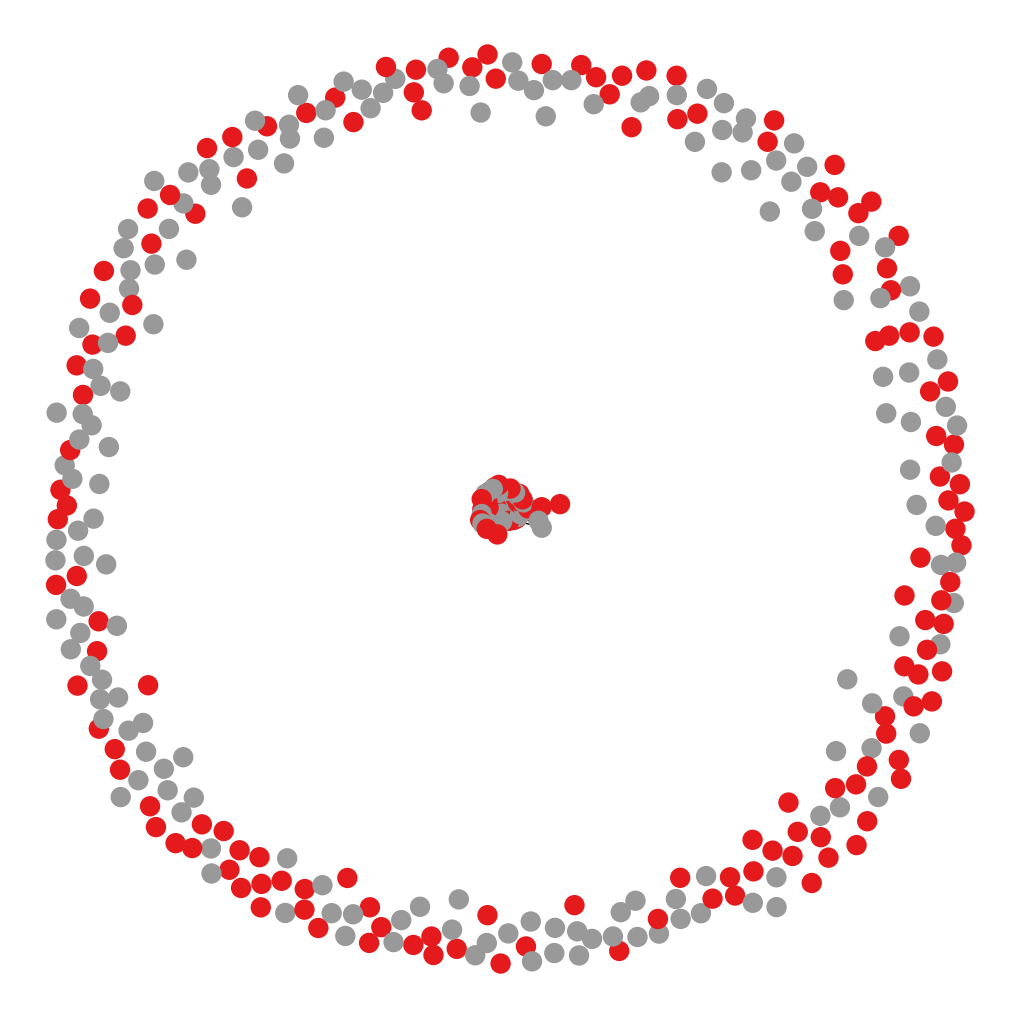

In [128]:
#Visualize the graph using networkx
data = test_data.data
plt.figure(figsize=(10, 10))
gcop = torch_geometric.data.Data(x=data.x[:500], edge_index=data.edge_index[:500])
g = torch_geometric.utils.to_networkx(gcop, to_undirected=True)
pubmedGraph = to_networkx(gcop)
node_labels = data.y[list(pubmedGraph.nodes)].numpy()
nx.draw(g, cmap=plt.get_cmap('Set1'),node_color = node_labels,node_size=75,linewidths=6)

In [129]:
#set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [173]:
# --- disregard this -- use normal sampling 
# Create batches with neighbor sampling
#A NeighborLoader is a data loader that performs neighbor sampling for GNN's
#Allows for mini-batch training of GNNs on large-scale graphs where full-batch training is not feasible.
#num_neighbors denotes how many neighbors are sampled for each node in each iteration.
#https://pytorch-geometric.readthedocs.io/en/latest/modules/loader.html#torch_geometric.loader.NeighborLoader
train_loader = NeighborLoader(
    train_data.data,
    num_neighbors=[5, 10],
    batch_size=16,
    input_nodes = None,
)

test_loader = NeighborLoader(
    test_data.data,
    num_neighbors=[5, 10],
    batch_size=16,
    input_nodes = None,
)

In [218]:
from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

### GCN ###

In [87]:
'''
Graph Convolutional Network
GCN takes graphs as an input and applies convolution operations over the graph
'''
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.005, weight_decay=5e-4)
    def forward(self, x, edge_index):
        # x: Node feature matrix 
        # edge_index: Graph connectivity matrix 
        #x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x, F.log_softmax(x, dim=1)

### GraphSage ###

In [220]:
'''
Graph SAGE: SAmpling and aggreGatE, 
Samples only a subset of neighboring nodes at different depth layers, 
and then the aggregator takes neighbors of the previous layers and aggregates them
'''
from torch_geometric.nn import global_max_pool as gmp

class GraphSAGE(torch.nn.Module):
  """GraphSAGE"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.sage1 = SAGEConv(dim_in, dim_h*2)
    self.sage2 = SAGEConv(dim_h*2, dim_h)
    self.sage3 = SAGEConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index, batch):
    h = self.sage1(x, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.sage2(h, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.2, training=self.training)
    h = self.sage3(h, edge_index)
    # Pooling
    h = gmp(h, batch) 
    #h = h.mean(dim = 0, keepdims = True) # this does not have a sampler marker to the batch, so we have to keep batch size as 1 
    return h, F.log_softmax(h, dim=1)

### GAT ###

In [89]:
'''
GAT- uses Attention stratgey
compute the hidden representations of each node in the Graph by attending 
over its neighbors using a self-attention strategy
'''
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.hid = 8
        self.in_head = 8
        self.out_head = 1
        
        self.conv1 = GATConv(dataset.num_features, self.hid, heads=self.in_head, dropout=0.6)
        self.conv2 = GATConv(self.hid*self.in_head, dataset.num_classes, concat=False,
                             heads=self.out_head, dropout=0.6)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.005, weight_decay=5e-4)

    def forward(self,x, edge_index):
        
        # Dropout before the GAT layer is used to avoid overfitting
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x,F.log_softmax(x, dim=1)



### Training Loop ###

In [221]:
from sklearn.metrics import accuracy_score, f1_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGE(train_data.num_features, 64, train_data.num_classes).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
#loss_fnc = torch.nn.BCELoss()
#loss_fnc = torch.nn.CrossEntropyLoss()
def train(epoch):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        _, out = model(data.x, data.edge_index, data.batch)
        #print(data.x.shape)
        #print(out.shape) # (size of nodes, no of classes)
        #print(data.y.shape) # no of graphs for that batch
        # this is cross entropy loss only - no idea why CrossEntropyLoss Function wouldn't work
        oh = F.one_hot(data.y,2).to(out)
        loss=-(out*oh).sum(dim=1).mean()
        #loss = loss_fnc(torch.reshape(out, (-1,)), data.y.long())
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test(epoch):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    for data in test_loader:
        data = data.to(device)
        _, out = model(data.x, data.edge_index, data.batch)
        oh = F.one_hot(data.y,2).to(out)
        loss=-(out*oh).sum(dim=1).mean()
        #loss = loss_fnc(torch.reshape(out, (-1,)), data.y.long())
        total_loss += float(loss) * data.num_graphs
        # get the probability of the predictions of each graph
        all_preds.append(torch.softmax(out,dim=1)) 
        #all_preds.append(torch.reshape(out, (-1,)))
        all_labels.append(data.y.float())

    # Calculate Metrics
    accuracy, f1 = metrics(all_preds, all_labels)

    return total_loss / len(test_loader.dataset), accuracy, f1

def metrics(preds, gts):
    # same as out.argmax(dim=1)
    preds = torch.cat(preds,dim=0).max(dim =1)[1].cpu().detach().numpy()
    gts = torch.cat(gts, dim=0).cpu().detach().numpy()
    acc = accuracy_score(preds, gts)
    f1 = f1_score(preds, gts)
    return acc, f1



In [222]:
for epoch in range(40):
    train_loss = train(epoch)
    test_loss, test_acc, test_f1 = test(epoch)
    print(f'Epoch: {epoch:02d} |  TrainLoss: {train_loss:.2f} | '
          f'TestLoss: {test_loss:.2f} | TestAcc: {test_acc:.2f} | TestF1: {test_f1:.2f}')

Epoch: 00 |  TrainLoss: 0.68 | TestLoss: 0.70 | TestAcc: 0.51 | TestF1: 0.68
Epoch: 01 |  TrainLoss: 0.65 | TestLoss: 0.75 | TestAcc: 0.51 | TestF1: 0.68
Epoch: 02 |  TrainLoss: 0.62 | TestLoss: 0.75 | TestAcc: 0.51 | TestF1: 0.68
Epoch: 03 |  TrainLoss: 0.59 | TestLoss: 0.85 | TestAcc: 0.51 | TestF1: 0.68
Epoch: 04 |  TrainLoss: 0.60 | TestLoss: 0.84 | TestAcc: 0.51 | TestF1: 0.68
Epoch: 05 |  TrainLoss: 0.57 | TestLoss: 1.02 | TestAcc: 0.51 | TestF1: 0.68
Epoch: 06 |  TrainLoss: 0.55 | TestLoss: 0.82 | TestAcc: 0.51 | TestF1: 0.68
Epoch: 07 |  TrainLoss: 0.55 | TestLoss: 0.86 | TestAcc: 0.51 | TestF1: 0.68
Epoch: 08 |  TrainLoss: 0.48 | TestLoss: 0.80 | TestAcc: 0.51 | TestF1: 0.68
Epoch: 09 |  TrainLoss: 0.45 | TestLoss: 0.86 | TestAcc: 0.51 | TestF1: 0.68
Epoch: 10 |  TrainLoss: 0.40 | TestLoss: 0.59 | TestAcc: 0.51 | TestF1: 0.68
Epoch: 11 |  TrainLoss: 0.38 | TestLoss: 1.01 | TestAcc: 0.51 | TestF1: 0.68
Epoch: 12 |  TrainLoss: 0.31 | TestLoss: 0.47 | TestAcc: 0.72 | TestF1: 0.79